<a href="https://colab.research.google.com/github/Krinal24/TensorFlow/blob/main/workshop_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning Fundamentals using Tensorflow

Steps in building model
- Preprocess the data
- Build the model (Create, Compile, Fit)
- Evaluate the model
- Tweak
- Evaluate
- Tweak
& so on
- Save and Deploy

Create, compile and fit - tf.keras - Sequential API and functional API are 2 ways to build the model.
[We use Sequential API in this notebook]

Improving the model -
Create step includes increasing number of layers or neurons or changing the activation function
Compile step includes tuning hyperparameters and changing optimizers or their learning rate
fit step includes increasing the number of epochs

Reminder - Types of problems in Supervised learning - Regression and Classification

Different datasets have different requirements in each step of building the ML model (some datasets may not need preprocessing, some may use it but might not listening to us change in )

##Preprocess the dataset


tf.keras.utils.image_dataset_from_directory and tf.keras.layers.Rescaling are used to read a directory of images on disk.

Standardization - center the data around a mean of zero and a standard deviation of one

Normalization - scales the data to a set range, often 0 to 1, by using the minimum and maximum value

train_test_split - split the dataset into 4 arrays - x_train, x_test, y_train, y_test

###Download the dataset

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

Download the flowers dataset
This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:


flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 8s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


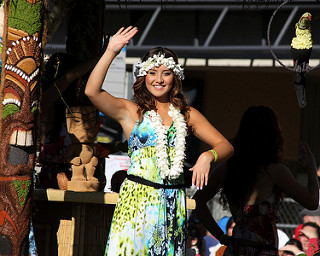

In [ ]:
#Checking out our dataset

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

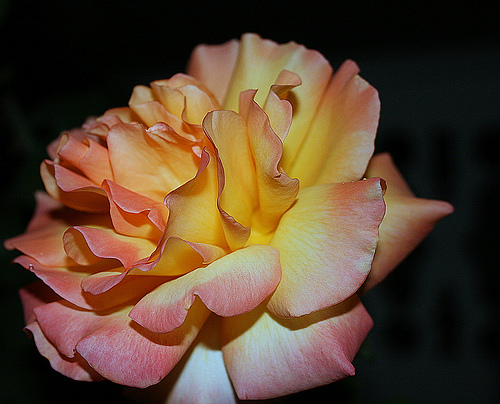

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

###Load the data

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


###Visualize the data

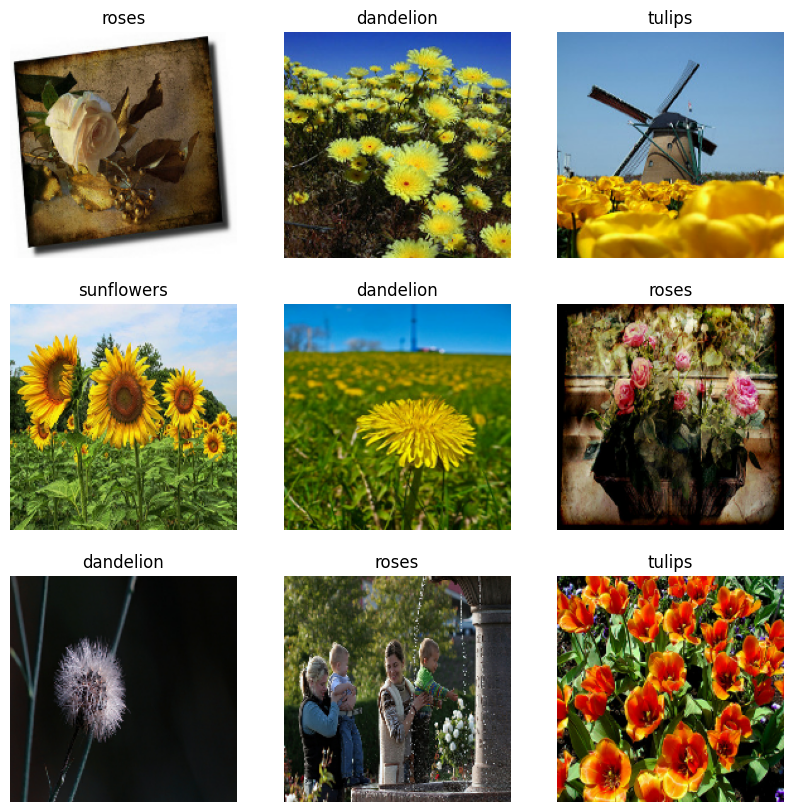

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

###Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling Dataset.map:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


Or, you can include the layer inside your model definition to simplify deployment.

- **Note**: If you would like to scale pixel values to [-1,1] you can instead write tf.keras.layers.Rescaling(1./127.5, offset=-1)

text vectorization is used in cases of text dataset to convert the string to token indices. Full code of preprocessing in that case is here -> https://www.tensorflow.org/tutorials/load_data/text

##Building and Evaluating a model

###Creating data

In [ ]:
from sklearn.datasets import make_circles

# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
# Check out the features
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [ ]:
# See the first 10 labels
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [ ]:
# Make dataframe of features and labels
import pandas as pd
circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [ ]:
# Check out the different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

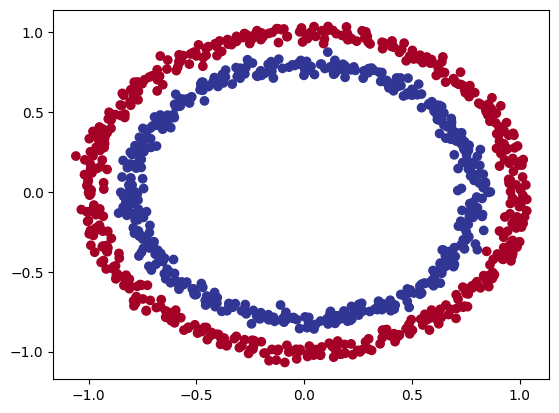

In [ ]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

###Steps in modelling

Now we know what data we have as well as the input and output shapes, let's see how we'd build a neural network to model it.

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

Creating a model - piece together the layers of a neural network yourself (using the functional or sequential API) or import a previously built model (known as transfer learning).

Compiling a model - defining how a model's performance should be measured (loss/metrics) as well as defining how it should improve (optimizer).

Fitting a model - letting the model try to find patterns in the data (how does X get to y).

Let's see these in action using the Sequential API to build a model for our regression data. And then we'll step through each.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model using the Sequential API
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), # binary since we are working with 2 clases (0 & 1)
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_1.fit(X, y, epochs=5)

Epoch 1/5
32/32 [==============================] - 1s 2ms/step - loss: 6.4812 - accuracy: 0.4890
Epoch 2/5
32/32 [==============================] - 0s 2ms/step - loss: 6.3916 - accuracy: 0.4860
Epoch 3/5
32/32 [==============================] - 0s 1ms/step - loss: 6.3506 - accuracy: 0.4890
Epoch 4/5
32/32 [==============================] - 0s 2ms/step - loss: 6.2861 - accuracy: 0.4840
Epoch 5/5
32/32 [==============================] - 0s 2ms/step - loss: 6.1625 - accuracy: 0.4930


In [ ]:
# Train our model for longer (more chances to look at the data)
model_1.fit(X, y, epochs=200, verbose=0) # set verbose=0 to remove training updates
model_1.evaluate(X, y)

32/32 [==============================] - 0s 3ms/step - loss: 7.7125 - accuracy: 0.5000


[7.712474346160889, 0.5]

Even after 200 passes of the data, it's still performing as if it's guessing.

What if we added an extra layer and trained for a little longer?

In [ ]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (same as model_1 but with an extra layer)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(1), # add an extra layer
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model
model_2.fit(X, y, epochs=100, verbose=0) # set verbose=0 to make the output print less

In [ ]:
# Evaluate the model
model_2.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.6933 - accuracy: 0.5000


[0.6932529807090759, 0.5]

Still not even as good as guessing (~50% accuracy)... hmm...?

Let's remind ourselves of a couple more ways we can use to improve our models.

![various options you can use to improve a neural network model](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-improving-a-model-from-model-perspective.png)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# 1. Create the model (this time 3 layers)
model_3 = tf.keras.Sequential([
  # Before TensorFlow 2.7.0
  # tf.keras.layers.Dense(100), # add 100 dense neurons

  # With TensorFlow 2.7.0
  # tf.keras.layers.Dense(100, input_shape=(None, 1)), # add 100 dense neurons

  ## After TensorFlow 2.8.0 ##
  tf.keras.layers.Dense(100), # add 100 dense neurons
  tf.keras.layers.Dense(10), # add another layer with 10 neurons
  tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(), # use Adam instead of SGD
                metrics=['accuracy'])

# 3. Fit the model
model_3.fit(X, y, epochs=100, verbose=1) # fit for 100 passes of the data

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 3.6314 - accuracy: 0.4450
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8269 - accuracy: 0.4760
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7039 - accuracy: 0.4580
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6969 - accuracy: 0.4710
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.4760
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4580
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6940 - accuracy: 0.5040
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6950 - accuracy: 0.4980
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6947 - accuracy: 0.4970
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.6943 - accuracy: 0.4400
Epoch 11/

Let's make some visualizations to see what's happening.

To visualize our model's predictions we're going to create a function plot_decision_boundary() which:

Takes in a trained model, features (X) and labels (y).
Creates a meshgrid of the different X values.
Makes predictions across the meshgrid.
Plots the predictions as well as a line between the different zones (where each unique class falls).

In [ ]:
import numpy as np

def plot_decision_boundary(model, X, y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

313/313 [==============================] - 1s 2ms/step
doing binary classifcation...


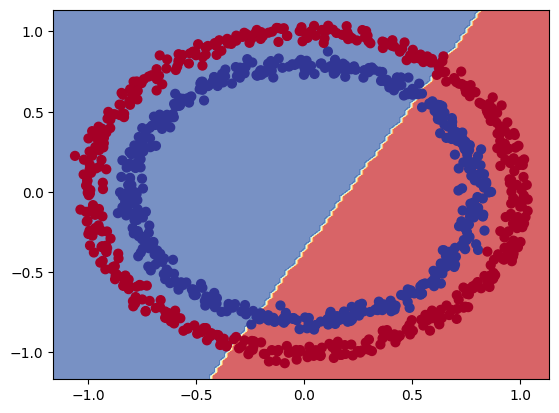

In [ ]:
# Check out the predictions our model is making
plot_decision_boundary(model_3, X, y)

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and blue circles), we're going to need some non-linear lines.

🔨 Practice: Before we get to the next steps, I'd encourage you to play around with the TensorFlow Playground (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

Did you try out the activation options? If so, what did you find?

If you didn't, don't worry, let's see it in code.

The main change we'll add to models we've built before is the use of the activation keyword.

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.linear), # 1 hidden layer with linear activation
  tf.keras.layers.Dense(1) # output layer
])

# Compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # note: "lr" used to be what was used, now "learning_rate" is favoured
                metrics=["accuracy"])

# Fit the model
history = model_4.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 4.2573 - accuracy: 0.4350
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 4.1317 - accuracy: 0.4490
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 3.9715 - accuracy: 0.4570
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 3.8454 - accuracy: 0.4570
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 3.7449 - accuracy: 0.4580
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 3.6360 - accuracy: 0.4580
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 3.4595 - accuracy: 0.4580
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 3.2646 - accuracy: 0.4570
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 2.9951 - accuracy: 0.4640
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 2.7798 - accuracy: 0.4690
Epoch 11/

313/313 [==============================] - 0s 1ms/step
doing binary classifcation...


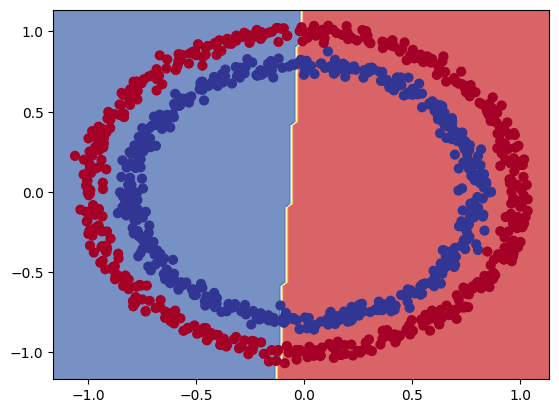

In [ ]:
# Check the deicison boundary (blue is blue class, yellow is the crossover, red is red class)
plot_decision_boundary(model_4, X, y)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model with a non-linear activation
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.keras.activations.relu), # can also do activation='relu'
  tf.keras.layers.Dense(1) # output layer
])

# Compile the model
model_5.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history = model_5.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 2.9982 - accuracy: 0.4820
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 2.5235 - accuracy: 0.4790
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 2.3656 - accuracy: 0.4780
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 2.2966 - accuracy: 0.4780
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 2.2101 - accuracy: 0.4790
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 2.0378 - accuracy: 0.4740
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 1.6738 - accuracy: 0.4760
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 1.4589 - accuracy: 0.4750
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3778 - accuracy: 0.4730
Epoch 10/100
32/32 [==============================] - 0s 3ms/step - loss: 1.3165 - accuracy: 0.4730
Epoch 11/

Hmm... still not learning...

What we if increased the number of neurons and layers?

Say, 2 hidden layers, with ReLU, pronounced "rel-u", (short for rectified linear unit), activation on the first one, and 4 neurons each?

To see this network in action, check out the TensorFlow Playground demo.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, 4 neurons, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, 4 neurons, ReLU activation
  tf.keras.layers.Dense(1) # ouput layer
])

# Compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Adam's default learning rate is 0.001
                metrics=['accuracy'])

# Fit the model
history = model_6.fit(X, y, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 2ms/step - loss: 1.4232 - accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 1.1022 - accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9821 - accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 0.9042 - accuracy: 0.4990
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8516 - accuracy: 0.4610
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 0.8190 - accuracy: 0.4190
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7989 - accuracy: 0.4120
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7849 - accuracy: 0.4290
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7733 - accuracy: 0.4480
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 0.7638 - accuracy: 0.4480
Epoch 11/

In [ ]:
# Evaluate the model
model_6.evaluate(X, y)

32/32 [==============================] - 0s 2ms/step - loss: 0.3666 - accuracy: 0.8380


[0.3666124939918518, 0.8379999995231628]

313/313 [==============================] - 0s 1ms/step
doing binary classifcation...


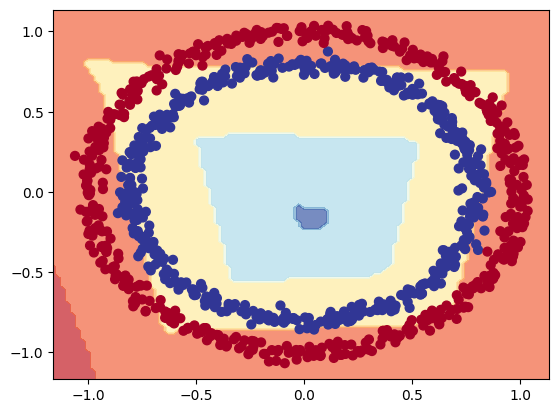

In [ ]:
# Check out the predictions using 2 hidden layers
plot_decision_boundary(model_6, X, y)

blue is blue class, yellow is the crossover, red is red class and yellow line should go between the red and the blue line

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

This time we'll change the activation function on our output layer too. Remember the architecture of a classification model? For binary classification, the output layer activation is usually the Sigmoid activation function.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history = model_7.fit(X, y, epochs=100, verbose=0)

In [ ]:
# Evaluate our model
model_7.evaluate(X, y)

32/32 [==============================] - 0s 1ms/step - loss: 0.2762 - accuracy: 0.9650


[0.27619263529777527, 0.9649999737739563]

Woah! It looks like our model is getting some incredible results, let's check them out.

313/313 [==============================] - 0s 1ms/step
doing binary classifcation...


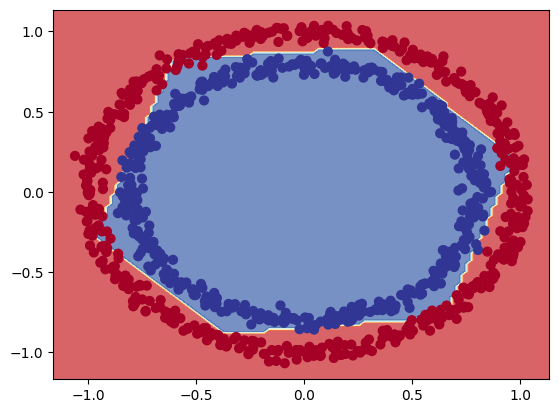

In [ ]:
# View the predictions of the model with relu and sigmoid activations
plot_decision_boundary(model_7, X, y)

 it's important to recognize what we've just covered.

🔑 Note: The combination of linear (straight lines) and non-linear (non-straight lines) functions is one of the key fundamentals of neural networks.

We've been evaluating our model on the same data it was trained on.

In [ ]:
# Split data into train and test sets
X_train, y_train = X[:800], y[:800] # 80% of the data for the training set
X_test, y_test = X[800:], y[800:] # 20% of the data for the test set

# Check the shapes of the data
X_train.shape, X_test.shape # 800 examples in the training set, 200 examples in the test set

((800, 2), (200, 2))

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create the model (same as model_7)
model_8 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"), # hidden layer 1, using "relu" for activation (same as tf.keras.activations.relu)
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid") # output layer, using 'sigmoid' for the output
])

# Compile the model
model_8.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), # increase learning rate from 0.001 to 0.01 for faster learning
                metrics=['accuracy'])

# Fit the model
history = model_8.fit(X_train, y_train, epochs=25)

Epoch 1/25
25/25 [==============================] - 1s 2ms/step - loss: 0.6976 - accuracy: 0.4675
Epoch 2/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.4925
Epoch 3/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6860 - accuracy: 0.5138
Epoch 4/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5537
Epoch 5/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.5713
Epoch 6/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6642 - accuracy: 0.5550
Epoch 7/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6562 - accuracy: 0.5900
Epoch 8/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6515 - accuracy: 0.5913
Epoch 9/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6429 - accuracy: 0.6413
Epoch 10/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6312 - accuracy: 0.6112
Epoch 11/25
25/25 [

In [ ]:
# Evaluate our model on the test set
loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Model loss on the test set: {loss}")
print(f"Model accuracy on the test set: {100*accuracy:.2f}%")

7/7 [==============================] - 0s 3ms/step - loss: 0.1766 - accuracy: 0.9900
Model loss on the test set: 0.17663228511810303
Model accuracy on the test set: 99.00%


Now, when we started to create model_8 we said it was going to be the same as model_7 but you might've found that to be a little lie.

That's because we changed a few things:

- The activation parameter - We used strings ("relu" & "sigmoid") instead of using library paths (tf.keras.activations.relu), in TensorFlow, they both offer the same functionality.

- The learning_rate (also lr) parameter - We increased the learning rate parameter in the Adam optimizer to 0.01 instead of 0.001 (an increase of 10x).

- You can think of the learning rate as how quickly a model learns. The higher the learning rate, the faster the model's capacity to learn, however, there's such a thing as a too high learning rate, where a model tries to learn too fast and doesn't learn anything. We'll see a trick to find the ideal learning rate soon.

- The number of epochs - We lowered the number of epochs (using the epochs parameter) from 100 to 25 but our model still got an incredible result on both the training and test sets.

- One of the reasons our model performed well in even less epochs (remember a single epoch is the model trying to learn patterns in the data by looking at it once, so 25 epochs means the model gets 25 chances) than before is because we increased the learning rate.

We know our model is performing well based on the evaluation metrics but let's see how it performs visually.

313/313 [==============================] - 0s 1ms/step
doing binary classifcation...
313/313 [==============================] - 0s 1ms/step
doing binary classifcation...


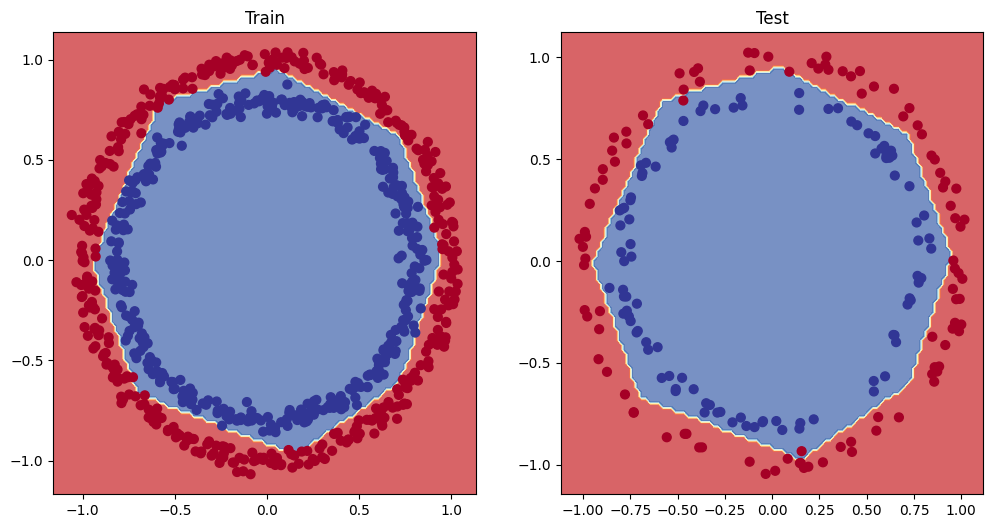

In [ ]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_8, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_8, X=X_test, y=y_test)
plt.show()

###Plot the loss curves

But how did our model go whilst it was learning?

As in, how did the performance change everytime the model had a chance to look at the data (once every epoch)?

To figure this out, we can check the loss curves (also referred to as the learning curves).

Text(0.5, 1.0, 'Model_8 training curves')

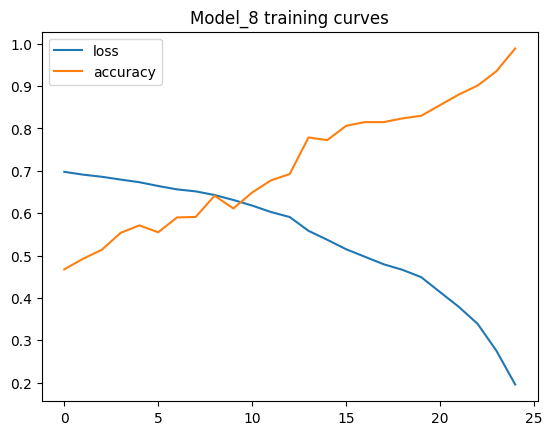

In [ ]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_8 training curves")

### More classification evaluation methods

Alongside the visualizations we've been making, there are a number of different evaluation metrics we can use to evaluate our classification models.

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) or [`tf.keras.metrics.Accuracy()`](tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) or [`tf.keras.metrics.Precision()`](tensorflow.org/api_docs/python/tf/keras/metrics/Precision) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) or [`tf.keras.metrics.Recall()`](tensorflow.org/api_docs/python/tf/keras/metrics/Recall) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | Custom function or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

In [ ]:
# Check the accuracy of our model
loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

7/7 [==============================] - 0s 3ms/step - loss: 0.1766 - accuracy: 0.9900
Model loss on test set: 0.17663228511810303
Model accuracy on test set: 99.00%


In [ ]:
y_preds = model_8.predict(X_test)

7/7 [==============================] - 0s 3ms/step


In [ ]:
# View the first 10 predictions
y_preds[:10]

array([[0.94343454],
       [0.92171586],
       [0.80808043],
       [0.91584605],
       [0.19193915],
       [0.19354789],
       [0.7000633 ],
       [0.08865807],
       [0.9370355 ],
       [0.06364388]], dtype=float32)

In [ ]:
# Convert prediction probabilities to binary format and view the first 10
tf.round(y_preds)[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.]], dtype=float32)>

In [ ]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
confusion_matrix(y_test, tf.round(y_preds))

array([[99,  2],
       [ 0, 99]])

**Neural Network Task !!**

##Fashion MNIST - The "Hello World" of Machine Learning